In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections as cs
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression

## Set default Seaborn plot style
sns.set(style="darkgrid")

## Import Titanic test data - confirm all required variables available
url = 'https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Titanic/test.csv'
test_df = pd.read_csv(url)
# test_df = pd.read_csv("../input/test.csv")

## Preview results
test_df.head(5)

## Results confirm data set does not contain all required variables for analysis

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
## Import Titanic training data - Test data set does not include survival as a variable
train_url = 'https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Titanic/train.csv'
train_df = pd.read_csv(train_url)
#train_df = pd.read_csv("../input/train.csv")

## Preview results
train_df.head(5)

## Results confirm data set does contain all required variables for analysis (inclusive of Survived as a dependent variable)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
## Analyze the data
train_df.info()

## Results confirm that there are 891 records total
## Null values appear in the data set (Age - 177; Cabin - 687; Embarked - 2)
## Do we need all of these variables in the model?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


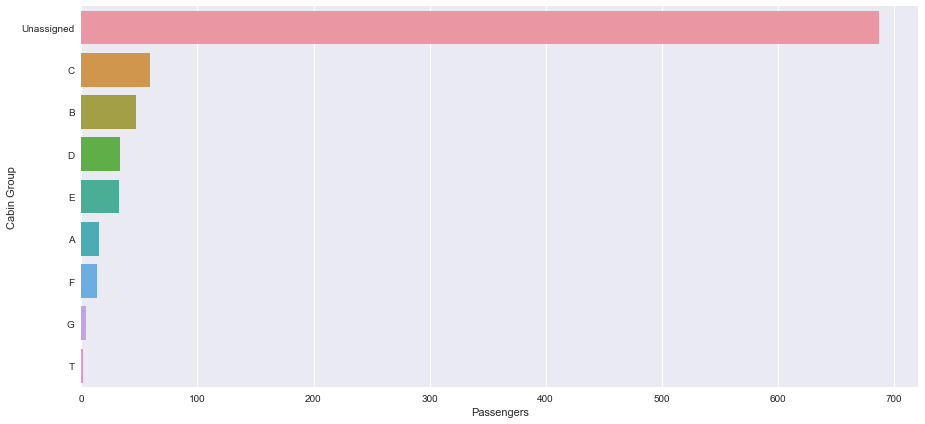

77% or (687) of passengers are not assigned to a cabin.


In [14]:
## Let's assess cabin's, and assign a grouping by cabin type.
train_df['Cabin Cleansed'] = train_df['Cabin'].astype(str).str[0]
train_df['Cabin_Cleansed'] = train_df['Cabin Cleansed'].replace('n','Unassigned')
#train_df['Cabin_Cleansed'] = train_df['Cabin_Cleansed'].replace('n','Unassigned')

## Let's build a chart to further analyze the data
plt.figure(figsize=(15,7))
ax = sns.countplot(y="Cabin_Cleansed", data=train_df, order = train_df['Cabin_Cleansed'].value_counts().index)
ax.set(xlabel='Passengers', ylabel='Cabin Group')
plt.show()

## How can we further interpret the results?
cabin_null = train_df['Cabin'].isnull().sum()
total_pass = len(train_df)
print("{0:.0f}%".format(round((cabin_null/total_pass),2) * 100) + " or (" + str(cabin_null) + ") of passengers are not assigned to a cabin.")

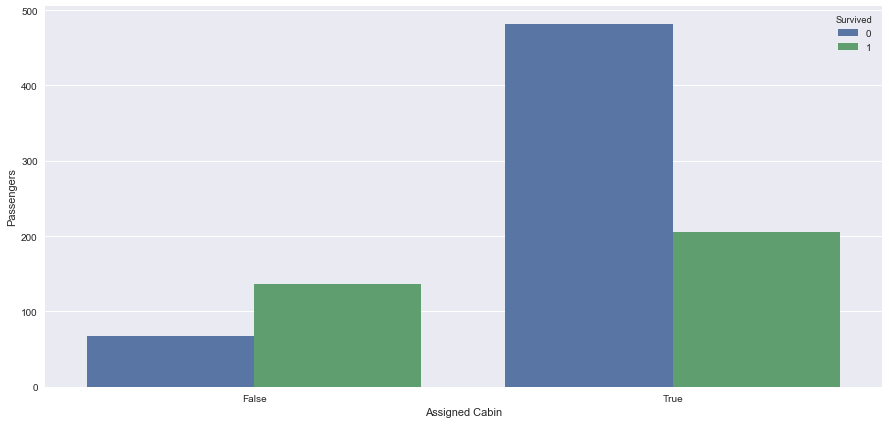

In [17]:
## Let's look at how being assigned to a cabin affected survival . . . maybe we don't have to replace the NULL values.
train_df['Assigned Cabin'] = train_df['Cabin'].isnull()

## Time to plot the data
plt.figure(figsize=(15,7))
bx = sns.countplot(x='Assigned Cabin', hue='Survived', data=train_df)
bx.set(ylabel='Passengers')
plt.show()

## It appears as though passengers who were assigned a cabin were less likely to survive
## We may want to include this variable in our model
train_df['Assigned_Cabin'] = train_df['Assigned Cabin']*1

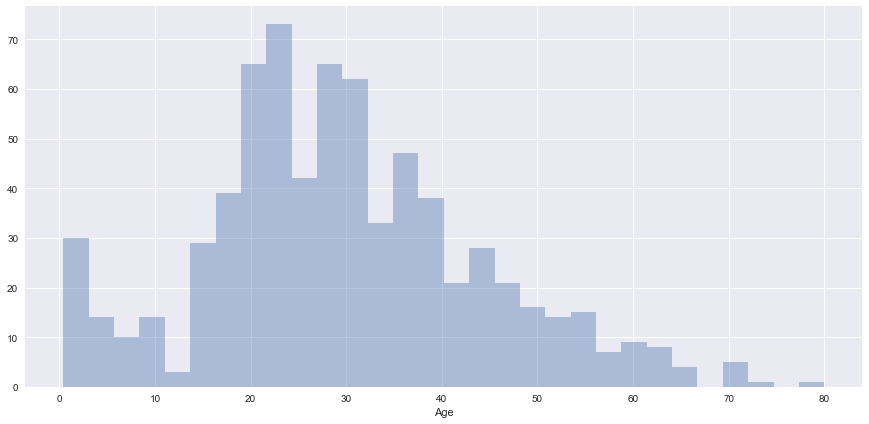

In [18]:
## Now let's take a look at the Age variable, which also had several NULL values
plt.figure(figsize=(15,7))
sns.distplot(train_df['Age'].dropna(), kde=False, bins = 30)
plt.show()

## NULL values needed to be replaced to build this chart, let's uncover a strategy to fill in these values.

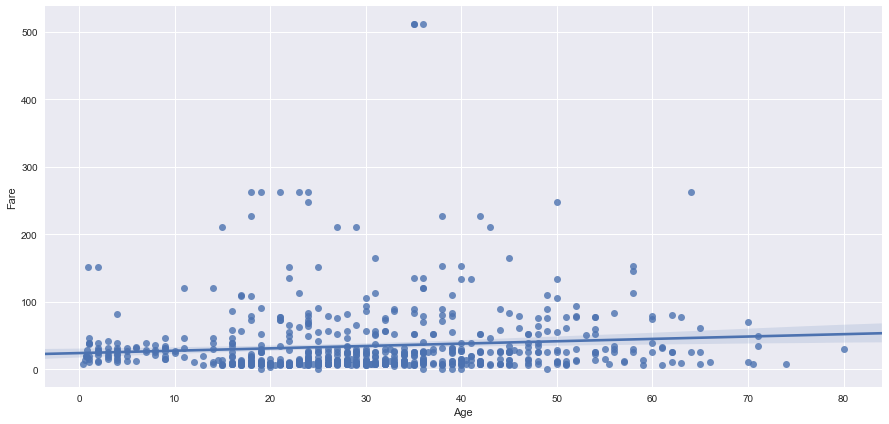

In [19]:
## Could we potentially predict age, based off of the fare paid?
plt.figure(figsize=(15,7))
sns.regplot(x="Age", y="Fare", data=train_df)
plt.show()

# No visible correlation between the variables, is there a better way?

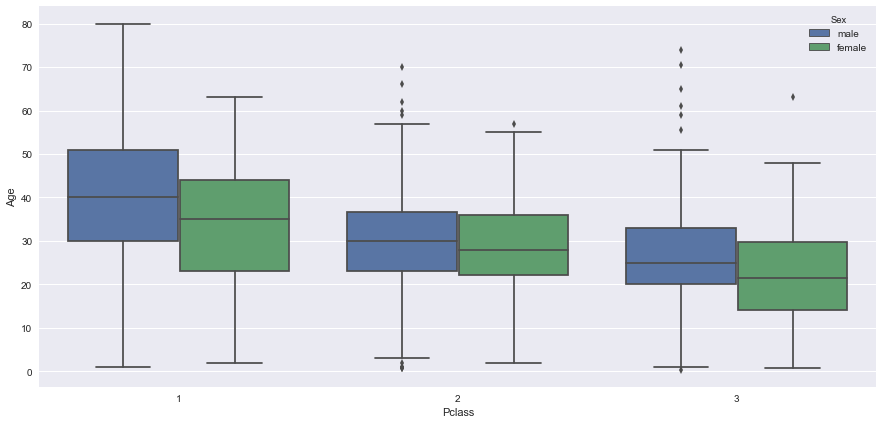

In [20]:
# Let's observe the spread of values between the Pclass and Age/Sex variables.
plt.figure(figsize=(15,7))
sns.boxplot(x="Pclass", y="Age", hue="Sex", data=train_df)
plt.show()

# Not to much spread between males/females, but there is certainly a spread between Pclass and Age.

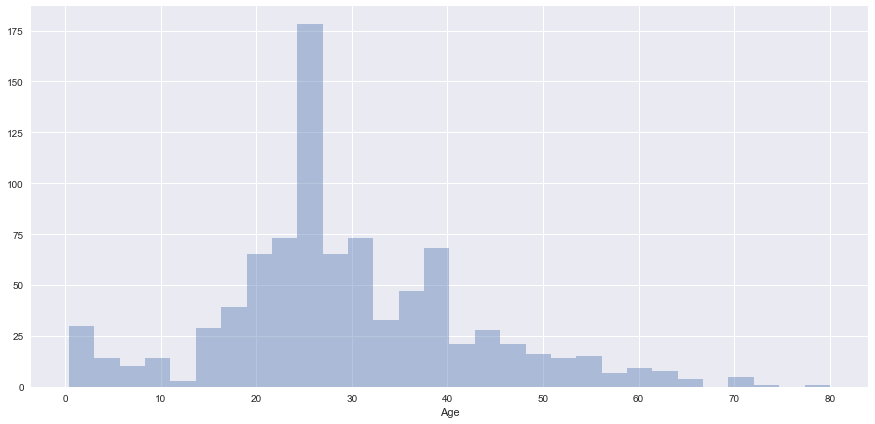

In [21]:
## Let's fill in the NULL age values, based off of the Pclass
train_df.Age = train_df.groupby(['Pclass'])['Age'].apply(lambda x: x.fillna(x.mean()))
train_df.Age = train_df.Age.fillna(train_df.Age.mean())

## Let's update our distribvution chart (without having to drop NULL values)
plt.figure(figsize=(15,7))
sns.distplot(train_df['Age'], kde=False, bins = 30)
plt.show()

## We are now closer to a normal distribution for this variable

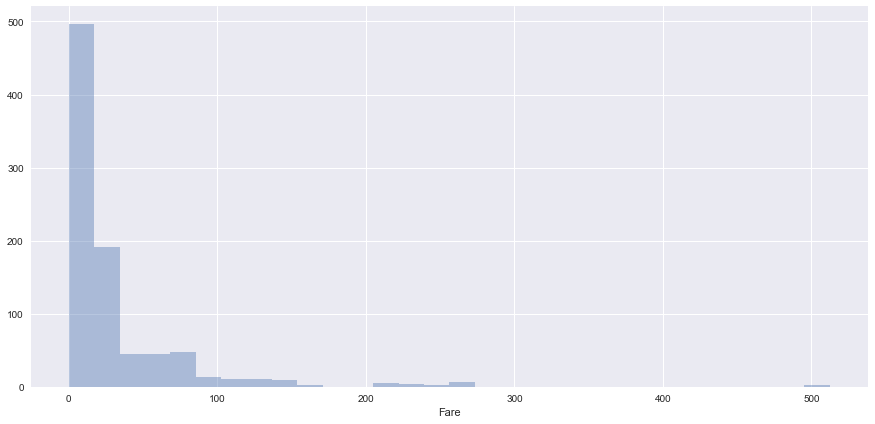

In [22]:
## Now let's take a look at the fare distribution
plt.figure(figsize=(15,7))
sns.distplot(train_df['Fare'], kde=False, bins = 30)
plt.show()

## This data is heavily right skewed.

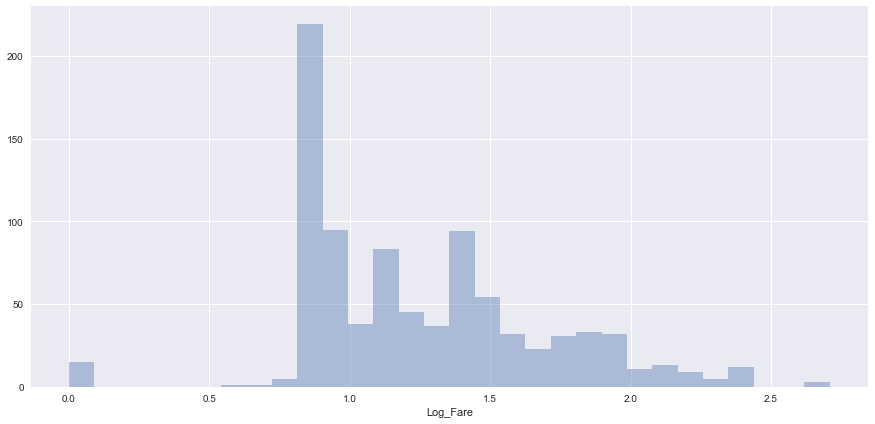

In [23]:
## Let's apply a log transformation and check the distribution.
train_df['Log_Fare'] = train_df.apply(lambda row: 0 if row['Fare'] in (0,1) else np.log10(row.Fare), axis=1)

## Time to plot the data.
plt.figure(figsize=(15,7))
sns.distplot(train_df['Log_Fare'], kde=False, bins = 30)
plt.show()

## While the data is still skewed, it is reflecting a more normal distribution.

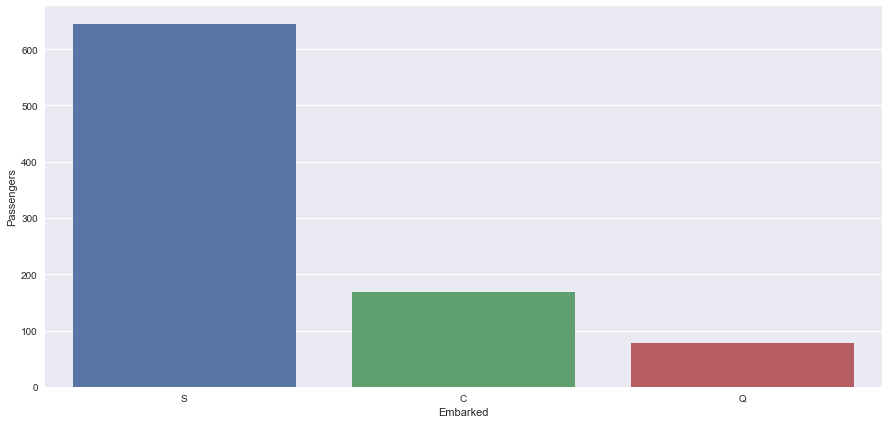

There are 2 passengers with no defined origin.


In [24]:
## Let's check the last variable where there are NULL values
plt.figure(figsize=(15,7))
cx = sns.countplot(x='Embarked',data=train_df)
cx.set(ylabel='Passengers')
plt.show()
print("There are " + str(train_df['Embarked'].isnull().sum()) + " passengers with no defined origin.")

## Given that there are only a few folks who are missing an Embarked value, we can assume they originated from the most popular origin.

In [25]:
## Let's find out who these passengers are, and what additional details we can infer
train_df[train_df['Embarked'].isnull()]

## Given there is no clear details to help derive the point of embarkment, we will leverage the most popular embarkement value 'S'.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Cleansed,Cabin_Cleansed,Assigned Cabin,Assigned_Cabin,Log_Fare
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,B,False,0,1.90309
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,B,False,0,1.90309


In [26]:
## Let's replace both NULL values with the most common embarkment point
train_df.loc[train_df['Embarked'].isnull(), 'Embarked'] = 'S'

In [27]:
## Analyze the data again, to confirm critical NULL values have been updated
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null object
Age               891 non-null float64
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null float64
Cabin             204 non-null object
Embarked          891 non-null object
Cabin Cleansed    891 non-null object
Cabin_Cleansed    891 non-null object
Assigned Cabin    891 non-null bool
Assigned_Cabin    891 non-null int64
Log_Fare          891 non-null float64
dtypes: bool(1), float64(3), int64(6), object(7)
memory usage: 112.3+ KB


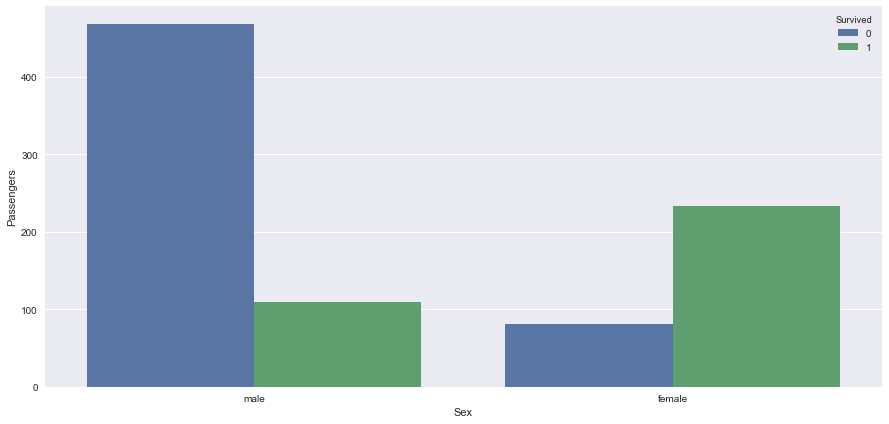

In [28]:
## Let's look at another view variables, to get an understanding for this data
plt.figure(figsize=(15,7))
dx = sns.countplot(x='Sex', hue='Survived', data=train_df)
dx.set(ylabel='Passengers')
plt.show()

## Looks like quite a few more female passengers survived

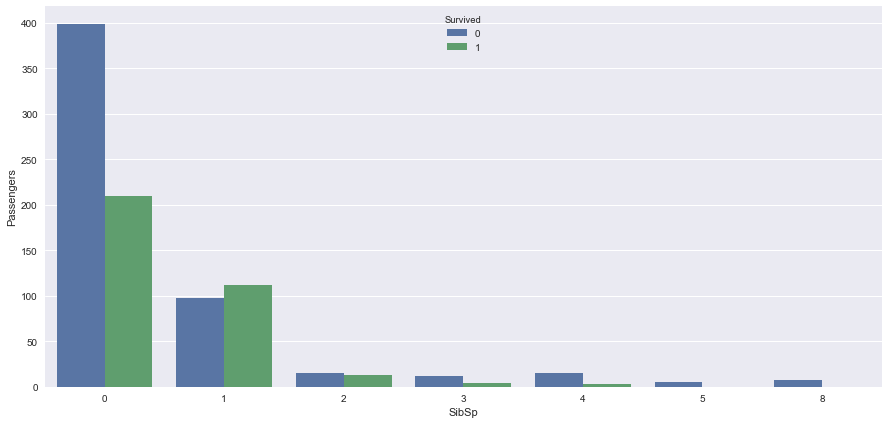

In [29]:
## Now let's take a look at the SibSp (Sibling/Spouse) variable
plt.figure(figsize=(15,7))
ex = sns.countplot(x='SibSp', hue='Survived', data=train_df)
ex.set(ylabel='Passengers')
plt.show()

## The ratio of passengers who survived vs. perished is pretty evenly split for all sibling/spouse groupings, except for single passengers where the survival rate is significantly smaller.

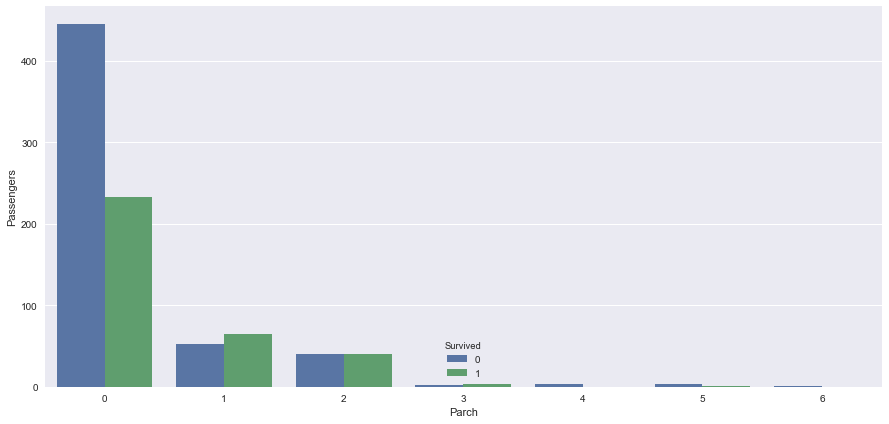

In [30]:
## Now let's take a look at the Parch (Parents/Children) variable
plt.figure(figsize=(15,7))
fx = sns.countplot(x='Parch', hue='Survived', data=train_df)
fx.set(ylabel='Passengers')
plt.show()

## Similar results as seen with the SibSp variable, where the survival rate of single passengers is significantly smaller.

In [31]:
## As single passengers have drastically higher popultations, let's simply these variables
train_df['Family'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['Alone'] = 0
train_df.loc[train_df['Family']==1,'Alone'] = 1

In [32]:
## Let's review all of the variables that we have in play
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Cleansed,Cabin_Cleansed,Assigned Cabin,Assigned_Cabin,Log_Fare,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,n,Unassigned,True,1,0.860338,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,C,False,0,1.852988,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,n,Unassigned,True,1,0.898999,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,C,False,0,1.725095,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,n,Unassigned,True,1,0.905796,1,1


In [33]:
## Now we need to create dummy variables for our categorical data
Class = pd.get_dummies(train_df['Pclass'], prefix='Class', drop_first=True)
Sex = pd.get_dummies(train_df['Sex'], prefix='Sex', drop_first=True)
Embarked = pd.get_dummies(train_df['Embarked'], prefix='Embarked', drop_first=True)

## Let's merge our existing data set w/ the new variables
train_df = pd.concat([train_df, Class, Sex, Embarked], axis=1)

## Let's review results - quite a few columns to be removed
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Assigned Cabin,Assigned_Cabin,Log_Fare,Family,Alone,Class_2,Class_3,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,True,1,0.860338,2,0,0,1,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,0,1.852988,2,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,True,1,0.898999,1,1,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,False,0,1.725095,2,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,True,1,0.905796,1,1,0,1,1,0,1


In [34]:
## We need to start removing variables, as we prepare for our final model
train_df.drop(['PassengerId'], axis=1, inplace=True) #High cardinality
train_df.drop(['Pclass'], axis=1, inplace=True) #Dummy variable created
train_df.drop(['Name'], axis=1, inplace=True) #High cardinality
train_df.drop(['Sex'], axis=1, inplace=True) #Dummy variable created
train_df.drop(['SibSp'], axis=1, inplace=True) #New variable created
train_df.drop(['Parch'], axis=1, inplace=True) #New variable created
train_df.drop(['Ticket'], axis=1, inplace=True) #High cardinality
train_df.drop(['Cabin'], axis=1, inplace=True) #New variable created
train_df.drop(['Embarked'], axis=1, inplace=True) #Dummy variable created
train_df.drop(['Cabin Cleansed'], axis=1, inplace=True) #New variable created
train_df.drop(['Cabin_Cleansed'], axis=1, inplace=True) #New variable created
train_df.drop(['Assigned Cabin'], axis=1, inplace=True) #New variable created
train_df.drop(['Family'], axis=1, inplace=True) #New variable created

In [35]:
## Let's review the results, and our final data frame
train_df.head(5)

,Survived,Age,Fare,Assigned_Cabin,Log_Fare,Alone,Class_2,Class_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,7.2500,1,0.860338,0,0,1,1,0,1
1,1,38.0,71.2833,0,1.852988,0,0,0,0,0,0
2,1,26.0,7.9250,1,0.898999,1,0,1,0,0,1
3,1,35.0,53.1000,0,1.725095,0,0,0,0,0,1
4,0,35.0,8.0500,1,0.905796,1,0,1,1,0,1


In [36]:
## Let's select the columns we want to leverage in our model
features = ["Age", "Fare", "Log_Fare", "Assigned_Cabin", "Alone", "Class_2", "Class_3", "Sex_male", "Embarked_Q", "Embarked_S"]
X = train_df[features]
Y = train_df['Survived']

In [37]:
## Time to execute our prediction
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit_model = sm.Logit(Y,X)
result = logit_model.fit()
print(result.summary())

## A few of the variables are reflecting P-values greater than an alpha of .05 . . . let's strip those out.

Optimization terminated successfully.
         Current function value: 0.452688
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Thu, 11 Jan 2018   Pseudo R-squ.:                  0.3202
Time:                        17:45:44   Log-Likelihood:                -403.34
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.567e-76
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age               -0.0246      0.007     -3.390      0.001      -0.039      -0.010
Fare             

In [38]:
## Let's select the columns we want to leverage in our model
features_2 = ["Fare", "Alone", "Class_2", "Sex_male",]
X_2 = train_df[features_2]

## Our original Log transformation on the Fare variable did not prove to be too valuable in this model

In [39]:
## Time to execute our NEW prediction
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit_model = sm.Logit(Y,X_2)
result = logit_model.fit()
print(result.summary())

## These variables look good

Optimization terminated successfully.
         Current function value: 0.494479
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Jan 2018   Pseudo R-squ.:                  0.2574
Time:                        17:46:04   Log-Likelihood:                -440.58
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 6.437e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fare           0.0159      0.002      7.285      0.000       0.012       0.020
Alone          0.3173      0.

In [40]:
## Model 1 results
logreg = LogisticRegression()
logreg.fit(X, Y)
logreg.score(X, Y)

0.80246913580246915

In [41]:
## Model 2 Results
logreg.fit(X_2, Y)
logreg.score(X_2, Y)

## Given that our test data set did not contain a survived variable (reason we used the primary training data set all the way through), when applying this model to the entire data set, and after refining our variable selection, we received a logistic regression score of 78% . . . this is pretty darn good!

0.78226711560044893